## random reference
## random constraint
## only tracking (no constraint)

In [23]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("cuda is available")
else:
    print("cuda is NOT available")

import numpy as np
from tqdm import tqdm
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import time
import copy
from moving_average import moving_average_1d

import importlib
import policy
importlib.reload(policy)
from policy import PolicyNN

from nn_functions import surrogate

import sys
sys.path.append('../1_model')
from TiDE import TideModule, quantile_loss  


cuda is available


# read data

In [24]:
df_all = pd.read_csv('../0_data/merged_df_2_99_temp_depth.csv')
print(df_all.shape)
print(df_all.columns)

nan_rows = df_all[df_all.isna().any(axis=1)]

df_all = df_all.dropna()

loc_X = df_all["X"].to_numpy().reshape(-1,1)
loc_Y = df_all["Y"].to_numpy().reshape(-1,1)
loc_Z = df_all["Z"].to_numpy().reshape(-1,1)
dist_X = df_all["Dist_to_nearest_X"].to_numpy().reshape(-1,1)
dist_Y = df_all["Dist_to_nearest_Y"].to_numpy().reshape(-1,1)
# dist_Z = df_all["Dist_to_nearest_Z"].to_numpy()[::2].reshape(-1,1)
scan_spd = df_all["scanning_speed"].to_numpy().reshape(-1,1)
laser_power = df_all["Laser_power"].to_numpy().reshape(-1,1)
laser_on_off = df_all["laser_power_number"].to_numpy().reshape(-1,1)

# apply moving average for mp temp
mp_temp_raw = df_all["melt_pool_temperature"].to_numpy()
mp_temp_mv = moving_average_1d(mp_temp_raw,4)
mp_temp = copy.deepcopy(mp_temp_raw)
mp_temp[1:-2] = mp_temp_mv
mp_temp = mp_temp.reshape(-1,1)

# apply moving average for mp depth
mp_depth_raw = df_all["melt_pool_depth"].to_numpy()
mp_depth_mv = moving_average_1d(mp_depth_raw,4)
mp_depth = copy.deepcopy(mp_depth_raw)
mp_depth[1:-2] = mp_depth_mv
mp_depth = mp_depth.reshape(-1,1)       


(610615, 12)
Index(['time_index', 'melt_pool_temperature', 'melt_pool_depth',
       'scanning_speed', 'X', 'Y', 'Z', 'Dist_to_nearest_X',
       'Dist_to_nearest_Y', 'Dist_to_nearest_Z', 'Laser_power',
       'laser_power_number'],
      dtype='object')


## normalize

In [25]:
# stack input array
x_original_scale = np.concatenate((loc_Z, dist_X, dist_Y, laser_power), axis=1)
y_original_scale = np.concatenate((mp_temp, mp_depth), axis=1)

# scaling
x_max = np.max(x_original_scale,0).reshape(1,-1)
x_min = np.min(x_original_scale,0).reshape(1,-1) 
y_max = np.max(y_original_scale,0).reshape(1,-1) 
y_min = np.min(y_original_scale,0).reshape(1,-1)

print("x_max:", np.round(x_max, 3).tolist())
print("x_min:", np.round(x_min, 3).tolist())
print("y_max:", np.round(y_max, 3).tolist())
print("y_min:", np.round(y_min, 3).tolist())

x_max: [[7.5, 20.0, 20.0, 732.298]]
x_min: [[0.0, 0.75, 0.75, 504.26]]
y_max: [[4509.855, 0.551]]
y_min: [[436.608, -0.559]]


In [26]:
class scalers():
    def __init__(self,x_max, x_min, y_max, y_min) -> None:
        self.x_max = x_max
        self.x_min = x_min
        self.y_max = y_max
        self.y_min = y_min
        
        return None
    
    def scaler_x(self, x_original, dim_id = -1):
        if dim_id == -1:
            x_s = -1 + 2 * ((x_original - self.x_min) / (self.x_max-self.x_min))
            return x_s
        else: 
            x_s = -1 + 2 * (x_original - self.x_min[0,dim_id]) / (self.x_max[0,dim_id] - self.x_min[0,dim_id])
            return x_s
    
    def inv_scaler_x(self, x_s, dim_id = -1):
        
        if dim_id == -1:
            x_original = (x_s + 1)*0.5*(self.x_max-self.x_min) + self.x_min
            return x_original
        else: 
            x_original = (x_s + 1)*0.5*(self.x_max[0,dim_id] - self.x_min[0,dim_id]) + self.x_min[0,dim_id]
            return x_original
        
    def scaler_y(self, y_original):
        return -1 + 2 * ((y_original - self.y_min) / (self.y_max-self.y_min))
    
    def inv_scaler_y(self, y_s):
        return (y_s + 1)*0.5*(self.y_max-self.y_min) + self.y_min

In [27]:
scaler = scalers(x_max, x_min, y_max, y_min)

x_s = scaler.scaler_x(x_original_scale)
y_s = scaler.scaler_y(y_original_scale)

print("x_s range:", np.min(x_s), "to", np.max(x_s))
print("y_s range:", np.min(y_s), "to", np.max(y_s))

print("x_s shape:", x_s.shape)
print("y_s shape:", y_s.shape)

x_s range: -1.0 to 1.0
y_s range: -1.0 to 1.0
x_s shape: (610417, 4)
y_s shape: (610417, 2)


## generate data

In [28]:
length = y_s.shape[0]

y_s_ref = np.random.uniform(0.0, 1.0, size=(length, 1))

e = 0.0001
y_depth_low = 0*np.random.uniform(0.1423-e, 0.1423+e, size = (length,1))
y_depth_up = 0*np.random.uniform(0.4126-e, 0.4126+e, size = (length,1))
# constraints!
#y_depth_low = 0*np.random.uniform(0.0, 0.5, size=(length, 1))
#y_depth_up = 0*np.random.uniform(0.5, 1.0, size=(length, 1))

y_s_const = np.concatenate((y_depth_low, y_depth_up), axis=1)

print("y_s_ref shape:", y_s_ref.shape)
print("y_s_const shape:", y_s_const.shape)

y_s_ref shape: (610417, 1)
y_s_const shape: (610417, 2)


## split data

In [29]:
import numpy as np
import torch
from tqdm import tqdm

# ─── Split train/val from time-series ───────────────────────────
cutoff_index = int(np.round(0.9 * x_s.shape[0]))
x_train, y_train = x_s[:cutoff_index], y_s[:cutoff_index]
x_val, y_val = x_s[cutoff_index:], y_s[cutoff_index:]
y_const_train, y_const_val = y_s_const[:cutoff_index], y_s_const[cutoff_index:]

window = 50
P = 50

# ─── Oversampling settings ──────────────────────────────────────
linear_lower = -0.2
linear_upper = 0.5
uniform_lower = -1.0
uniform_upper = 0.2
oversample_factor = 10  # same for both modes

# ─── Identify indices for oversampling ──────────────────────────
linear_oversample_indices = []
uniform_oversample_indices = []

for i in range(window, cutoff_index - P):
    y_ref_seq = y_train[i:i+P, 0]
    if np.all((y_ref_seq >= linear_lower) & (y_ref_seq <= linear_upper)):
        linear_oversample_indices.append(i)
    if np.all((y_ref_seq >= uniform_lower) & (y_ref_seq <= uniform_upper)):
        uniform_oversample_indices.append(i)

# ─── Create training sequences (including oversampling) ─────────
x_past_list, y_past_list = [], []
x_future_list, y_ref_list, y_const_list = [], [], []

# First, add all original training sequences (1x)
original_count = 0
for i in range(window, cutoff_index - P):
    x_past = x_train[i-window:i]
    y_past = y_train[i-window:i]
    x_fut = x_train[i:i+P, :3]
    y_ref = y_train[i:i+P, :1]
    y_const = y_const_train[i:i+P]

    scalar_shift = torch.empty(1).uniform_(-0.1, 0.1).item()
    u_last_shift = torch.empty(1).uniform_(-0.1, 0.1).item()
    x_past[-1, 3] += u_last_shift  # apply u_last_shift

    x_past_list.append(x_past)
    y_past_list.append(y_past)
    x_future_list.append(x_fut)
    y_ref_list.append(y_ref + scalar_shift)
    y_const_list.append(y_const)
    original_count += 1

# ─── Apply linear oversampling ─────────────────────────────────
linear_oversampled_count = 0
for i in tqdm(linear_oversample_indices, desc="Linear oversampling"):
    x_past = x_train[i-window:i]
    y_past = y_train[i-window:i]
    x_fut = x_train[i:i+P, :3]
    y_ref = y_train[i:i+P, :1]
    y_const = y_const_train[i:i+P]

    T_mean = y_ref.mean()
    rep = int(np.clip(
        oversample_factor * (1 - (T_mean - linear_lower) / (linear_upper - linear_lower)),
        0, oversample_factor
    ))
    for _ in range(rep):
        scalar_shift = torch.empty(1).uniform_(-0.1, 0.1).item()
        u_last_shift = torch.empty(1).uniform_(-0.1, 0.1).item()
        x_past_aug = x_past.copy()
        x_past_aug[-1, 3] += u_last_shift

        x_past_list.append(x_past_aug)
        y_past_list.append(y_past)
        x_future_list.append(x_fut)
        y_ref_list.append(y_ref + scalar_shift)
        y_const_list.append(y_const)
        linear_oversampled_count += 1

# ─── Apply uniform oversampling ────────────────────────────────
uniform_oversampled_count = 0
for i in tqdm(uniform_oversample_indices, desc="Uniform oversampling"):
    x_past = x_train[i-window:i]
    y_past = y_train[i-window:i]
    x_fut = x_train[i:i+P, :3]
    y_ref = y_train[i:i+P, :1]
    y_const = y_const_train[i:i+P]

    for _ in range(oversample_factor):
        scalar_shift = torch.empty(1).uniform_(-0.1, 0.1).item()
        u_last_shift = torch.empty(1).uniform_(-0.1, 0.1).item()
        x_past_aug = x_past.copy()
        x_past_aug[-1, 3] += u_last_shift

        x_past_list.append(x_past_aug)
        y_past_list.append(y_past)
        x_future_list.append(x_fut)
        y_ref_list.append(y_ref + scalar_shift)
        y_const_list.append(y_const)
        uniform_oversampled_count += 1

# ─── Convert to torch tensors ───────────────────────────────────
x_past_train = torch.tensor(np.stack(x_past_list), dtype=torch.float32)
y_past_train = torch.tensor(np.stack(y_past_list), dtype=torch.float32)
x_future_train = torch.tensor(np.stack(x_future_list), dtype=torch.float32)
y_ref_train_seq = torch.tensor(np.stack(y_ref_list), dtype=torch.float32)
y_const_train_seq = torch.tensor(np.stack(y_const_list), dtype=torch.float32)

# ─── Print counts and shape summary ─────────────────────────────
print(f"Original training sequence count        : {original_count}")
print(f"Linear oversampled additional count     : {linear_oversampled_count}")
print(f"Uniform oversampled additional count    : {uniform_oversampled_count}")
print(f"Total training sequence count           : {len(x_past_list)}\n")

print("x_past_train shape      :", x_past_train.shape)
print("y_past_train shape      :", y_past_train.shape)
print("x_future_train shape    :", x_future_train.shape)
print("y_ref_train_seq shape   :", y_ref_train_seq.shape)
print("y_const_train_seq shape :", y_const_train_seq.shape)




# ─── Validation set (no oversampling) ───────────────────────────
val_cutoff = x_s.shape[0] - cutoff_index
n_val = val_cutoff - P - window

x_past_val = np.empty((n_val, window, 4))
y_past_val = np.empty((n_val, window, 2))
x_future_val = np.empty((n_val, P, 3))
y_ref_val_seq = np.empty((n_val, P, 1))
y_const_val_seq = np.empty((n_val, P, 2))

for i in tqdm(range(window, val_cutoff - P), desc="Building validation set"):
    j = i - window
    x_past_val[j] = x_val[i-window:i]
    y_past_val[j] = y_val[i-window:i]
    x_future_val[j] = x_val[i:i+P, :3]
    scalar_shift = torch.empty(1).uniform_(-0.1, 0.1).item()
    y_ref_val_seq[j] = y_val[i:i+P, :1] + scalar_shift
    y_const_val_seq[j] = y_const_val[i:i+P]

x_past_val = torch.tensor(x_past_val, dtype=torch.float32)
y_past_val = torch.tensor(y_past_val, dtype=torch.float32)
x_future_val = torch.tensor(x_future_val, dtype=torch.float32)
y_ref_val_seq = torch.tensor(y_ref_val_seq, dtype=torch.float32)
y_const_val_seq = torch.tensor(y_const_val_seq, dtype=torch.float32)

# ─── Print shape summary ────────────────────────────────────────
print("x_past_val shape        :", x_past_val.shape)
print("y_past_val shape        :", y_past_val.shape)
print("x_future_val shape      :", x_future_val.shape)
print("y_ref_val_seq shape     :", y_ref_val_seq.shape)
print("y_const_val_seq shape   :", y_const_val_seq.shape)


Uniform oversampling: 100%|██████████| 27690/27690 [00:02<00:00, 10355.31it/s]


Original training sequence count        : 549275
Linear oversampled additional count     : 151223
Uniform oversampled additional count    : 276900
Total training sequence count           : 977398

x_past_train shape      : torch.Size([977398, 50, 4])
y_past_train shape      : torch.Size([977398, 50, 2])
x_future_train shape    : torch.Size([977398, 50, 3])
y_ref_train_seq shape   : torch.Size([977398, 50, 1])
y_const_train_seq shape : torch.Size([977398, 50, 2])


Building validation set: 100%|██████████| 60942/60942 [00:00<00:00, 101084.59it/s]

x_past_val shape        : torch.Size([60942, 50, 4])
y_past_val shape        : torch.Size([60942, 50, 2])
x_future_val shape      : torch.Size([60942, 50, 3])
y_ref_val_seq shape     : torch.Size([60942, 50, 1])
y_const_val_seq shape   : torch.Size([60942, 50, 2])


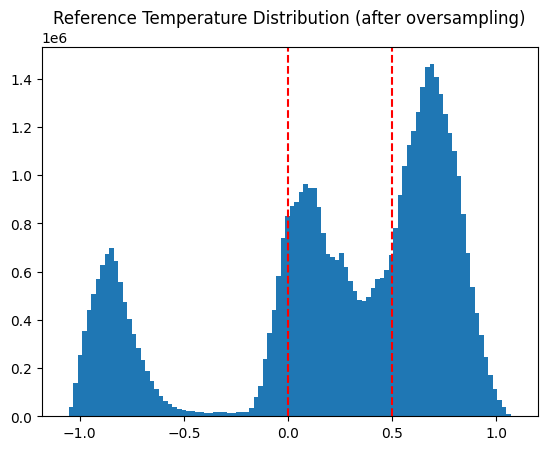

In [30]:
import matplotlib.pyplot as plt
plt.hist(y_ref_train_seq[:, :, 0].flatten().numpy(), bins=100)
plt.axvline(0, color='r', linestyle='--')
plt.axvline(0.5, color='r', linestyle='--')
plt.title("Reference Temperature Distribution (after oversampling)")
plt.show()


In [31]:
batch_size = 512

# Make sure your training/validation tensors are torch.Tensor before this line
train_dataset = TensorDataset(x_past_train, y_past_train, x_future_train, y_ref_train_seq, y_const_train_seq)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_past_val, y_past_val, x_future_val, y_ref_val_seq, y_const_val_seq)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# loss function


In [32]:
def DPC_loss(x_past: torch.Tensor, tide_output: torch.Tensor, reference: torch.Tensor, u_output: torch.Tensor, constraint: torch.Tensor,
             w_tracking=1.0, w_smooth=0, w_constraint=0):
    
    tide_output = tide_output.median(dim=-1).values
    tide_output_temp = tide_output[:, :, 0]
    reference = reference[:, :, 0]
    tracking_loss = (reference - tide_output_temp) ** 2

    u_diff = u_output[:, 1:, :] - u_output[:, :-1, :]
    # u_diff_2 = x_past[:, -1, 3] - u_output[:,   0, :] ## added for smoothness loss
    smoothness_loss = u_diff ** 2 
    # smoothness_loss_2 = u_diff_2 ** 2

    tide_output_depth = tide_output[:, :, 1]
    low_violation = torch.relu(constraint[:, :, 0] - tide_output_depth) ** 2
    up_violation = torch.relu(tide_output_depth - constraint[:, :, 1]) ** 2
    constraint_loss = 0 * low_violation + up_violation

    loss = (
        w_tracking * torch.sqrt(tracking_loss.mean()) +
        w_smooth * (torch.sqrt(smoothness_loss.mean())) + # +torch.sqrt(smoothness_loss_2.mean())) +
        w_constraint * torch.sqrt(constraint_loss.mean())
    )
    return loss


In [33]:
import torch
import pickle

# Load model
with open('TiDE_params_single_track_square_MV_temp_depth_less_cov_0915_w50_p50.pkl', 'rb') as file:
    nominal_params = pickle.load(file)

TiDE = nominal_params['model'].to(device)
total_params = sum(p.numel() for p in TiDE.parameters())

In [34]:
import pickle
import os

def train_and_evaluate(n_layers, hidden_dim, setting_name,
                       w_smooth, w_constraint):
    model = PolicyNN(
        past_input_dim=6,
        future_input_dim=6,
        output_dim=1,
        p=50,
        window=50,
        hidden_dim=hidden_dim,
        n_layers=n_layers,
        dropout_p=0.1
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.95)

    best_model = None
    best_val_loss = float("inf")
    save_train_loss = np.zeros(num_epoch)
    save_val_loss = np.zeros(num_epoch)
    counter = 0

    with tqdm(total=num_epoch, desc=setting_name) as pbar:
        model.train()
        for epoch in range(num_epoch):

            for x_past, y_past, x_future, y_ref, y_const in train_loader:
                x_past, y_past, x_future, y_ref, y_const = (
                    x_past.to(device), y_past.to(device),
                    x_future.to(device), y_ref.to(device), y_const.to(device)
                )

                policy_in_past = torch.cat((x_past, y_past), dim=2)
                policy_in_future = torch.cat((x_future, y_ref, y_const), dim=2)

                optimizer.zero_grad()

                u_output = model((policy_in_past, policy_in_future))
                x_future_tide = torch.cat((x_future, u_output), dim=2)
                past_cov = torch.cat((y_past, x_past), dim=2)

                tide_pred = TiDE((past_cov, x_future_tide, None))
                loss = DPC_loss(x_past, tide_pred, y_ref, u_output, y_const,
                                w_tracking=1.0, w_smooth=w_smooth, w_constraint=w_constraint)

                loss.backward()
                optimizer.step()

            # validation
            model.eval()
            val_loss_total = 0.0
            num_val_batches = 0

            with torch.no_grad():
                for val_x_past, val_y_past, val_x_future, val_y_ref, val_y_const in val_loader:
                    val_x_past, val_y_past, val_x_future, val_y_ref, val_y_const = (
                        val_x_past.to(device), val_y_past.to(device),
                        val_x_future.to(device), val_y_ref.to(device), val_y_const.to(device)
                    )

                    val_policy_in_past = torch.cat((val_x_past, val_y_past), dim=2)
                    val_policy_in_fut = torch.cat((val_x_future, val_y_ref, val_y_const), dim=2)

                    val_u_output = model((val_policy_in_past, val_policy_in_fut))

                    x_future_tide_val = torch.cat((val_x_future, val_u_output), dim=2)
                    past_cov_val = torch.cat((val_y_past, val_x_past), dim=2)

                    val_tide_pred = TiDE((past_cov_val, x_future_tide_val, None))
                    val_loss = DPC_loss(val_x_past, val_tide_pred, val_y_ref, val_u_output, val_y_const,
                                        w_tracking=1.0, w_smooth=w_smooth, w_constraint=w_constraint)

                    val_loss_total += val_loss.item()
                    num_val_batches += 1

            val_loss_avg = val_loss_total / num_val_batches

            if val_loss_avg < best_val_loss:
                best_val_loss = val_loss_avg
                best_model = model.state_dict()
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    break

            save_train_loss[epoch] = loss.item()
            save_val_loss[epoch] = val_loss_avg
            scheduler.step()
            pbar.set_description(f"{setting_name} | Epoch {epoch} | Train: {loss.item():.4f} | Val: {val_loss_avg:.4f}")
            pbar.update(1)


    # directory where you want to store all results
    train_dir = "/home/ftk3187/github/DPC_research/02_DED/4_policy_0725/trainresults"
    os.makedirs(train_dir, exist_ok=True)

    # build filename and full path
    model_filename = f"policy_model_{setting_name}_oversampling.pth"
    model_path = os.path.join(train_dir, model_filename)

    # save and report
    torch.save(best_model, model_path)
    print(f"Saved model to: {model_path}")

    # Save model parameters as .pkl
    model_params = {
        "model_name": setting_name,
        "past_input_dim": 6,
        "future_input_dim": 6,
        "output_dim": 1,
        "future_cov_dim": 2,
        "static_cov_dim": 0,
        "window": 50,
        "p": 50,
        "hidden_dim": hidden_dim,
        "n_layers": n_layers,
        "learning_rate": learning_rate,
        "weight_decay": weight_decay,
        "num_epoch": num_epoch,
        "w_smooth": w_smooth,
        "w_constraint": w_constraint
    }

    train_dir = "/home/ftk3187/github/DPC_research/02_DED/4_policy_0725/trainresults"
    os.makedirs(train_dir, exist_ok=True)

    # save model parameters
    param_filename = f"policy_parameters_{setting_name}_oversampling.pkl"
    param_path = os.path.join(train_dir, param_filename)
    with open(param_path, "wb") as f:
        pickle.dump(model_params, f)
    print(f"Saved model parameters to: {param_path}")

    return {
        "train_loss": save_train_loss,
        "val_loss": save_val_loss
    }


In [35]:
import torch
import os
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import numpy as np
import pickle

# Hyperparameters
num_epoch = 20
learning_rate = 1e-3
weight_decay = 1e-5
patience = 100

target_configs = [
    (3, 1024, 1, 0),  # s0c0
]

# Results dictionary
results = {}

# Run training for each configuration
for n_layers, hidden_dim, w_smooth, w_constraint in target_configs:
    setting_name = f"{n_layers}L_{hidden_dim}H_s{w_smooth}_c{w_constraint}"
    print(f"\n▶ Training model: {setting_name}")

    result = train_and_evaluate(
        n_layers=n_layers,
        hidden_dim=hidden_dim,
        setting_name=setting_name,
        w_smooth=w_smooth,
        w_constraint=w_constraint
    )
    results[setting_name] = result



▶ Training model: 3L_1024H_s1_c0


3L_1024H_s1_c0:   0%|          | 0/20 [00:00<?, ?it/s]

3L_1024H_s1_c0 | Epoch 19 | Train: 0.0437 | Val: 0.0408: 100%|██████████| 20/20 [11:24<00:00, 34.22s/it]

Saved model to: /home/ftk3187/github/DPC_research/02_DED/4_policy_0725/trainresults/policy_model_3L_1024H_s1_c0_oversampling.pth
Saved model parameters to: /home/ftk3187/github/DPC_research/02_DED/4_policy_0725/trainresults/policy_parameters_3L_1024H_s1_c0_oversampling.pkl


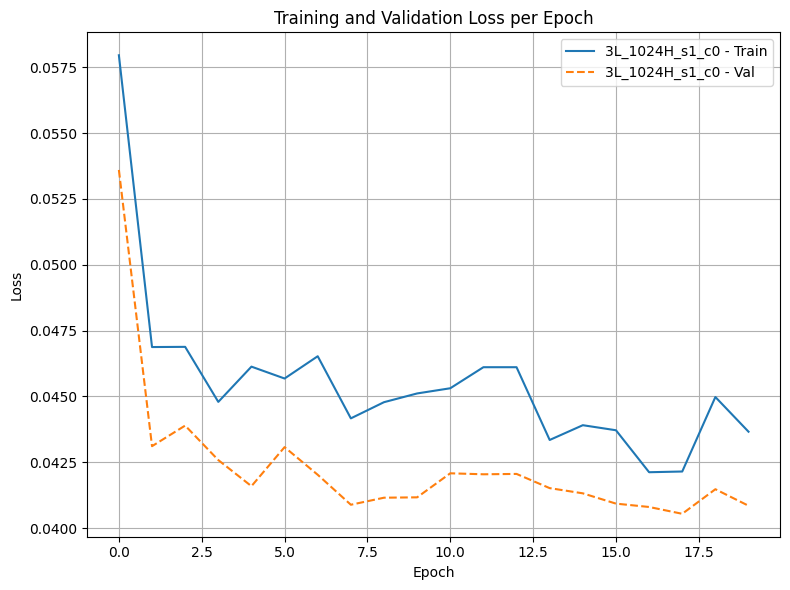

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for setting_name, result in results.items():
    plt.plot(result['train_loss'], label=f"{setting_name} - Train")
    plt.plot(result['val_loss'], label=f"{setting_name} - Val", linestyle='--')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
